## Part 2 - Dealing with Missing Data


**Notice: This notebook is a modification of [sniff.ipynb](https://mlbook.explained.ai/notebooks/index.html) by Terence Parr and Jeremy Howard, which was used by permission of the author.**

Please use this notebook to follow along with the lectures this week. Feel free to modify the code in any way. 

There may be minor differences between the notebook seen in the lecture videos and this one. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from rfpimp import * 

In [2]:
def evaluate(X, y, n_estimators=50):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

In [4]:
from pandas.api.types import is_string_dtype, is_object_dtype

def df_normalize_strings(df):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)

In [5]:
def extract_sizes(df, colname):
    df[colname] = df[colname].str.extract('(\d+\.\d+|\d+)', expand=True)
    df[colname] = df[colname].replace('', np.nan)
    df[colname] = pd.to_numeric(df[colname])

In [6]:
# modified version of: https://stackoverflow.com/questions/26986655/changing-height-feet-and-inches-to-an-integer-in-python-pandas

def parse_length(length):
    if length is not np.nan:
      split_length = length.split("' ")
      feet = float(split_length[0])
      inches = float(split_length[1].replace("\"",""))
      return (12*feet) + inches
    else:
      return np.nan

### Recap

It is a good idea to recap what we did to the data last time:

- dropped the `SalesID` and `MachineID` features;
- converted `auctioneerID` to 'string' data type so we can treat it as a categorical feature;
- decided to leave `Blade_Width` as 'string' and treat as a categorical feature instead of converting to numeric;
- extracted numeric features from the original `Undercarriage_Pad_Width` and `Tire_Size` strings;
- converted `Stick_Length` to a numeric feature from the original string representation;
- normalized the representation of missing values to `np.nan`.

### Next Steps

Our next steps will be to carry out the following:
- convert all 'string' features to ordered categorical features;
- label encode all these features using the value of 0 to represent missing data;
- fix some remaining problems with numeric columns; and 
- replace missing numeric data by:
    - adding a new feature to say whether or not that value was missing; 
    - replace missing values in the original feature with the median of all values for that feature.

### Reset Data

In this notebook we are going to pick up where we left off in **Part 1** so we'll load and process the data according to what we did in the last notebook. 

In [7]:
df_raw = pd.read_feather("bulldozer-train.feather")
df = df_raw.copy()
df = df.iloc[-100000:]

In [8]:
df.drop(['SalesID', 'MachineID'], axis=1, inplace=True)
df['auctioneerID'] = df['auctioneerID'].astype(str)
df_normalize_strings(df)
extract_sizes(df, 'Tire_Size')
extract_sizes(df, 'Undercarriage_Pad_Width')
df['Stick_Length'] = df['Stick_Length'].apply(lambda x: parse_length(x))

In [9]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

In [10]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
SalePrice,int64,0.000,574,"[8300, 15500, 26000, 80000, 77500, 17750, 4900..."
ModelID,int64,0.000,3703,"[4663, 11859, 1133, 457, 3858, 4584, 2249, 340..."
datasource,int64,0.000,5,"[136, 132, 121, 172, 149]"
YearMade,int64,0.000,63,"[1985, 1995, 1997, 1993, 2000, 1999, 2005, 199..."
Tire_Size,float64,85.891,12,"[nan, 26.5, 20.5, 17.5, 23.5, 14.0, 13.0, 29.5..."
Stick_Length,float64,93.602,25,"[nan, 126.0, 114.0, 115.0, 122.0, 152.0, 154.0..."
saledate,datetime64[ns],0.000,674,"[2009-01-23T00:00:00.000000000, 2009-01-24T00:..."
Undercarriage_Pad_Width,float64,96.806,18,"[nan, 36.0, 24.0, 20.0, 34.0, 26.0, 30.0, 28.0..."
MachineHoursCurrentMeter,float64,20.955,13175,"[0.0, nan, 2301.0, 2132.0, 212.0, 301.0, 3187...."
Backhoe_Mounting,object,99.998,2,"[nan, yes]"


### Handling Categorical Data

For this part we are going to use some built functionality of Pandas, as opposed to the `catgory_encoders` package we used last time. To see how this is going to work, we'll carry out our procedure on a toy dataframe first.

In [11]:
hyd = pd.DataFrame({'Hydraulics_Flow': df['Hydraulics_Flow'].unique()})
hyd

,Hydraulics_Flow
0,NaN
1,standard
2,high flow


In [12]:
hyd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Hydraulics_Flow  2 non-null      object
dtypes: object(1)
memory usage: 152.0+ bytes


Now we convert the feature `Hydraulics_Flow`, which is a string feature, to a categorical feature.

In [13]:
hyd['Hydraulics_Flow'] = hyd['Hydraulics_Flow'].astype('category').cat.as_ordered()
hyd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Hydraulics_Flow  2 non-null      category
dtypes: category(1)
memory usage: 255.0 bytes


Now we label encode the feature. 

In [14]:
hyd['default cat code'] = hyd['Hydraulics_Flow'].cat.codes
hyd

,Hydraulics_Flow,default cat code
0,NaN,-1
1,standard,1
2,high flow,0


And now we add 1 so that all missing values (`np.nan`) will be coded as 0. 

In [15]:
hyd['our cat code'] = hyd['Hydraulics_Flow'].cat.codes + 1
hyd

,Hydraulics_Flow,default cat code,our cat code
0,NaN,-1,0
1,standard,1,2
2,high flow,0,1


In practice we would do these two steps and replace the original feature with the encoded values. 

In [16]:
hyd = pd.DataFrame({'Hydraulics_Flow': df['Hydraulics_Flow'].unique()})
hyd['Hydraulics_Flow'] = hyd['Hydraulics_Flow'].astype('category').cat.as_ordered()
hyd['Hydraulics_Flow'] = hyd['Hydraulics_Flow'].cat.codes + 1
hyd

,Hydraulics_Flow
0,0
1,2
2,1


Since we have many string features that we would like to convert in this way, we will use functions to make applying this procedure to many features more efficient.

In [17]:
from pandas.api.types import is_categorical_dtype, is_string_dtype

def df_string_to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

Now we can convert all string features to categorical features and encode them with the following two lines of code. Note that we have also dealt with all the missing values, as they are encoded with the value of 0 for every feature. 

In [18]:
df_string_to_cat(df)
df_cat_to_catcode(df)

In [19]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
Turbocharged,int8,0.000,2,"[0, 1]"
Blade_Extension,int8,0.000,2,"[0, 1]"
Blade_Width,int8,0.000,6,"[0, 1, 3, 2, 4, 5]"
Enclosure_Type,int8,0.000,3,"[0, 1, 2]"
Engine_Horsepower,int8,0.000,3,"[0, 1, 2]"
Hydraulics,int8,0.000,12,"[1, 11, 4, 0, 2, 5, 3, 10, 6, 8, 7, 9]"
Pushblock,int8,0.000,2,"[0, 1]"
Ripper,int8,0.000,4,"[0, 2, 1, 3]"
Scarifier,int8,0.000,2,"[0, 1]"
Tip_Control,int8,0.000,3,"[0, 1, 2]"


At this point we have dealt with all of the categorical features and can now move on to dealing with missing values in the numeric features. 

### Notice

> **The unreasonable effectiveness of label encoding categorical variables**
*You might be wondering why it's “legal” to convert all of those unordered (nominal) categorical variables to ordered integers. We know for sure that assuming an order between categories is wrong. The short answer is that RF models can still partition such converted categorical features in a way that is predictive, possibly at the cost of a more complex tree model. This is definitely not true for many models, such as linear regression models (which require so-called “dummy” boolean columns, one for each unique categorical value* - [that is, one hot encoding]). *In practice, we've found label encoding categorical variables surprisingly effective, even when it seems more advanced methods would work better.* (Jeremy Howard and Terence Parr, end of Section 7.5.1 of *Mechanics of Machine Learning*)

### Handling Missing Values for Numeric Data

Now that the categorical features have been encoded and missing values have been taken care of we need to address the missing values in the remaining numeric features: `Tire_Size`, `Undercarriage_Pad_Width`, `YearMade`, `Stick_Length`, and `MachineHoursCurrentMeter`. 

The recipe we are going to use here consists of two steps: 
- create a boolean column that has a `True` entry if that corresponds to a missing value and `False` otherwise; and,
- fill in the missing values with the median value for that feature. 

To see how it will work in practice, let's try out our recipe on a toy dataset: 

In [20]:
df_toy = pd.DataFrame(data={'YearMade':[1995,2001,np.nan]})
df_toy

,YearMade
0,1995.0
1,2001.0
2,NaN


In step 1, we add a new boolean column to keep track of where the missing data was. 

In [21]:
df_toy['YearMade_na'] = df_toy['YearMade'].isnull()
df_toy

,YearMade,YearMade_na
0,1995.0,False
1,2001.0,False
2,NaN,True


And in step 2, we replace the missing value with the mean value for that feature. 

In [22]:
median_value = df_toy['YearMade'].median()
df_toy['YearMade'] = df_toy['YearMade'].fillna(median_value)
df_toy

,YearMade,YearMade_na
0,1995.0,False
1,2001.0,False
2,1998.0,True


We will use a function to apply both of these steps to any given feature in our data. 

In [23]:
def fix_missing_num(df, colname):
    df[colname+'_na'] = pd.isnull(df[colname])
    df[colname].fillna(df[colname].median(), inplace=True)

Before we start replacing, let's asses the situation with the remaining numeric features that have missing values to see if there are any remaining problems. 

In [24]:
df['Tire_Size'].unique()

array([ nan, 26.5, 20.5, 17.5, 23.5, 14. , 13. , 29.5, 15.5,  7. , 10. ,
       23.1])

In [25]:
df['Undercarriage_Pad_Width'].unique()

array([nan, 36., 24., 20., 34., 26., 30., 28., 32., 16., 31., 18., 22.,
       33., 14., 27., 25., 15.])

In [26]:
df['Stick_Length'].unique()

array([ nan, 126., 114., 115., 122., 152., 154., 118., 116., 132., 130.,
       102., 113., 169., 142.,  75., 148.,  98., 106., 100., 189., 166.,
       163., 184., 236.])

In [27]:
np.sort(df['MachineHoursCurrentMeter'].unique())

array([0.0000e+00, 2.0000e+00, 3.0000e+00, ..., 2.2024e+06, 2.4833e+06,
              nan])

In [28]:
np.sort(df['YearMade'].unique())

array([1000, 1919, 1920, 1948, 1951, 1952, 1953, 1954, 1956, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=int64)

It seems that `Tire_Size`, `Undercarriage_Pad_Width`, and `Stick_Length` are good to go so let's start with them. 

In [29]:
fix_missing_num(df, 'Tire_Size')
fix_missing_num(df, 'Undercarriage_Pad_Width')
fix_missing_num(df, 'Stick_Length')

And check that the missing numbers are now gone. 

In [30]:
df['Tire_Size'].unique()

array([20.5, 26.5, 17.5, 23.5, 14. , 13. , 29.5, 15.5,  7. , 10. , 23.1])

In [31]:
df['Undercarriage_Pad_Width'].unique()

array([30., 36., 24., 20., 34., 26., 28., 32., 16., 31., 18., 22., 33.,
       14., 27., 25., 15.])

In [32]:
df['Stick_Length'].unique()

array([118., 126., 114., 115., 122., 152., 154., 116., 132., 130., 102.,
       113., 169., 142.,  75., 148.,  98., 106., 100., 189., 166., 163.,
       184., 236.])

`YearMade` and `MachineHoursCurrentMeter` have some potential issues that we'll need to explore: 
- `YearMade` problem 1: it's doubtful that any bulldozers were made in the year 1000 so we will need to treat these as missing values. In fact some of the other entries seem suspicious so we will use a cutoff year of 1950; any year before 1950 we will consider as missing. So for this feature, we will need to:
    - replace all values below 1950 with `np.nan`; and then,
    - replace those missing values with the median value;
- `YearMade` problem 2: some of the bulldozers have sale dates that come before it was made. For these, we will:
    - replace the `YearMade` value with the sale date;
- `MachineHoursCurrentMeter`: some are listed as having been used for 0 hours; while this may indicate that they are new, the age of the bulldozers suggests that this is probably a missing value (or the owner did not want to put in the true value). For this we will need to:
    - replace the value of 0 with `np.nan`; and then,
    - replace the missing values with the median value

Let's fix `YearMade` first. 

In [33]:
df.loc[df.YearMade<1950, 'YearMade'] = np.nan
fix_missing_num(df, 'YearMade')

In [34]:
df.loc[df.eval("saledate.dt.year < YearMade"), 'YearMade'] = df['saledate'].dt.year

Now let's fix `MachineHoursCurrentMeter`. 

In [35]:
df.loc[df.eval("MachineHoursCurrentMeter==0"), 'MachineHoursCurrentMeter'] = np.nan
fix_missing_num(df, 'MachineHoursCurrentMeter')

And check that it worked. 

In [36]:
np.sort(df['MachineHoursCurrentMeter'].unique())

array([2.0000e+00, 3.0000e+00, 4.0000e+00, ..., 1.8571e+06, 2.2024e+06,
       2.4833e+06])

In [37]:
np.sort(df['YearMade'].unique())

array([1951., 1952., 1953., 1954., 1956., 1959., 1960., 1961., 1962.,
       1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970., 1971.,
       1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
       1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
       1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011.])

And check the final cleaned data set.

In [38]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
MachineHoursCurrentMeter_na,bool,0.0,2,"[True, False]"
Stick_Length_na,bool,0.0,2,"[True, False]"
Undercarriage_Pad_Width_na,bool,0.0,2,"[True, False]"
Tire_Size_na,bool,0.0,2,"[True, False]"
YearMade_na,bool,0.0,2,"[False, True]"
Enclosure_Type,int8,0.0,3,"[0, 1, 2]"
Engine_Horsepower,int8,0.0,3,"[0, 1, 2]"
Hydraulics,int8,0.0,12,"[1, 11, 4, 0, 2, 5, 3, 10, 6, 8, 7, 9]"
Pushblock,int8,0.0,2,"[0, 1]"
Ripper,int8,0.0,4,"[0, 2, 1, 3]"


We now have everything cleaned up except for `saledate`, which we'll tackle in the next notebook.

### Recall Our Baseline Model

In [39]:
basefeatures = ['SalesID', 'MachineID', 'ModelID',
                'datasource', 'YearMade',
                'auctioneerID', 'MachineHoursCurrentMeter']

In [40]:
df_baseline = df_raw.copy() 
df_baseline = df_baseline.iloc[-100000:]

In [41]:
X_baseline = df_baseline[basefeatures]
y_baseline = df_baseline['SalePrice']

X_baseline = X_baseline.fillna(0)

In [42]:
%%time
rf_baseline, oob_baseline_initial = evaluate(X_baseline, y_baseline, n_estimators=50)

OOB R^2 is 0.84553 using 5,556,456 tree nodes with 45.0 median tree depth
Wall time: 8.11 s


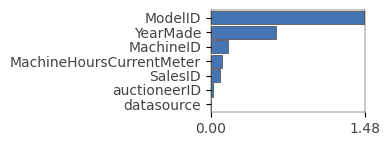

In [43]:
showimp(rf_baseline, X_baseline, y_baseline)

### Train a New Model

Now let's use our cleaned up data to train a new model and see if we have improved the performance compared to the baseline model. 

In [44]:
X  = df.drop(['SalePrice','saledate'], axis=1) 
y = df['SalePrice']

rf, oob_all = evaluate(X, y, n_estimators=50)

OOB R^2 is 0.89959 using 5,153,498 tree nodes with 43.0 median tree depth


We see that with the cleaned up features we get a nice increase in our OOB $R^2$ score. To see where else we may get an improvement, let's look at the feature importances. 

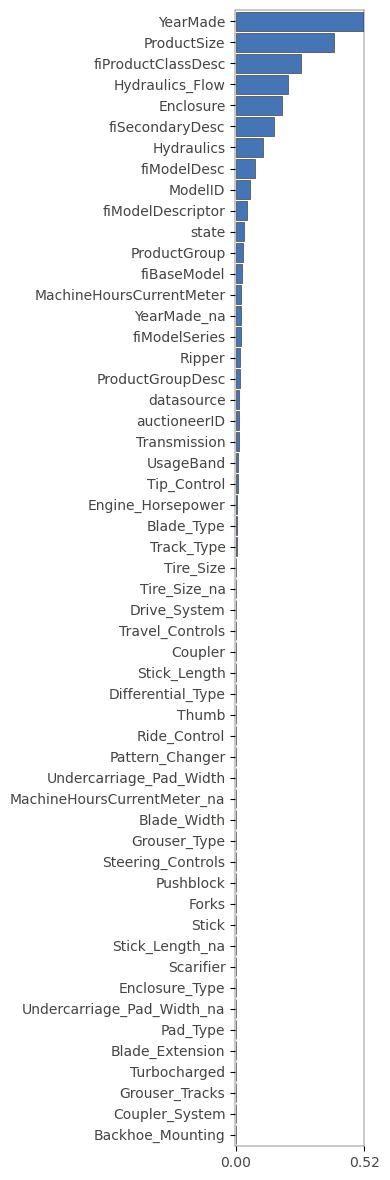

In [45]:
showimp(rf, X, y)

From the plot we can see what we should try next. There is not much left to do with `YearMade` but the other important features, like `Productsize`, `fiProductClassDesc`, `Enclosure`, `Hydraulics_Flow`, `fiSecondaryDesc`, etc deserve a closer look. Along with `saledate`, that is what we will do next

Before we finish, we will save our cleaned data so we don't have to repeat the cleaning process as we explore how to further improve our model's performance. 

### Save the Cleaned Data

In [46]:
df = df.reset_index(drop=True)
df.to_feather("bulldozer-train-clean.feather")